## Preliminaries

Import data and build graph

In [1]:
import numpy as np
import pandas as pd

city = "small"

edgelist = pd.read_csv("out/" + city + ".results.csv")
edgelist.head()

,edge_id,edge_from,edge_to,edge_length,edge_numLanes,edge_speed,flow,vehicle_speed
0,0,1614922744,1614922747,23.141939,2,29.0576,0.0,0.00
1,1,269459339,269459341,60.826398,5,29.0576,14274.0,25.65
2,2,1621320618,1621320622,109.464966,2,29.0576,1149.0,27.70
3,3,269459229,269459230,160.720645,3,29.0576,7974.0,25.03
4,4,607954833,1613371666,173.017706,3,29.0576,6504.0,26.02


In [2]:
import networkx as nx

G_undirected = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"])
H = nx.line_graph(G_undirected)
H.add_nodes_from((node, G_undirected.edges[node]) for node in H)

def smoothness(H, attr):
    L = nx.laplacian_matrix(H)
    x = np.array([attrs[attr] for _, attrs in H.nodes(data=True)])
    return x.transpose() @ L @ x

smoothness(H, "vehicle_speed") / H.number_of_nodes()

14.352409075907591

In [3]:
smoothness(H, "flow") / H.number_of_nodes()

8887190.131188119

## Iterative Greedy Algorithm

Write and test iterative algorithm

In [4]:
def fix_sensors(x, x_hat, sensors):
    fixed = np.copy(x_hat)
    for s in sensors:
        try:
            fixed[s] = x[s]
        except IndexError:
            print("indexerror:", s)
    return fixed

def predict(x, P, max_iter, sensors): 
    x_hat = fix_sensors(x, np.zeros(len(x)), sensors)        
    
    for t in range(max_iter):
        x_hat = fix_sensors(x, P @ x_hat, sensors)
    
    return x_hat

In [5]:
from tqdm.notebook import tqdm
from multiprocess import Pool 
from itertools import repeat
import heapq


"""
Choose `k` sensors greedily according to the loss function given by `evaluate` (lower loss is better). 
"""
def choose_sensors(G, attr, evaluate, k=None):    
    if k == None:
        k = int(G.number_of_nodes() / 50)
    
    # Convert node labels to 1,...,n
    node2idx = dict(zip(list(G.nodes()), range(G.number_of_nodes())))
    H = nx.relabel_nodes(G, node2idx)

    D = np.zeros((H.number_of_nodes(), H.number_of_nodes())) # Degree matrix
    x = np.zeros(H.number_of_nodes()) # True values
    for i, v in enumerate(H.nodes(data=True)):
        D[i][i] = H.degree[v[0]]
        x[i] = v[1][attr]
        
    P = np.linalg.inv(D) @ nx.adjacency_matrix(H)
    L = nx.laplacian_matrix(H)
    
    sensors = set()
        
    # Find value of adding each node not in the set
    with Pool(1) as pool:
        deltas = pool.map(lambda v: (-evaluate(v, sensors, x, P), v), range(H.number_of_nodes()))
        heapq.heapify(deltas)
    
    for i in tqdm(range(k)):        
        current = (np.square(x - predict(x, P, 1000, sensors))).mean()
        
        # Current top 
        _, s = heapq.heappop(deltas)
        delta = evaluate(s, sensors, x, P) - current
        
        # Next top
        delta_next, s_next = heapq.heappop(deltas)
        delta_next -= current
    
        # Compute change in top node
        # If the change drops it below the next best, recalculate the next best and continue
        while delta - delta_next > 1e-3:
            delta_next = evaluate(s_next, sensors, x, P) - current
            if delta_next <= delta:
                heapq.heappush(deltas, (delta, s))
                delta, s = delta_next, s_next
            else:
                heapq.heappush(deltas, (delta_next, s_next))
            delta_next, s_next = heapq.heappop(deltas)
        
        sensors.add(s)
        
    idx2node = {v: k for k, v in node2idx.items()}
    return set([idx2node[s] for s in sensors]), idx2node, predict(x, P, 1000, sensors), x

In [6]:
def evaluate_iterative_all(v, sensors, x, P):
    if v in sensors:
        return float("inf")

    pred = predict(x, P, 1000, sensors.union([v]))
    return (np.square(pred - x)).mean()

### Testing

Should choose one node from each colored cluster

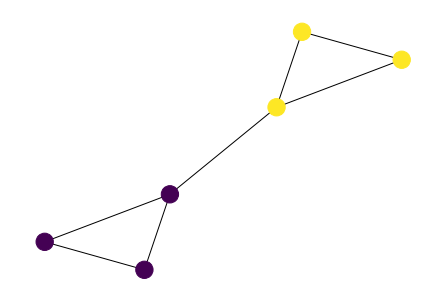

In [7]:
J = nx.Graph()
J.add_node(0, speed=0)
J.add_node(1, speed=0)
J.add_node(2, speed=0)

J.add_node(3, speed=10)
J.add_node(4, speed=10)
J.add_node(5, speed=10)

J.add_edges_from([(0, 1), (1, 2), (2, 0), (2, 3), (3, 4), (4, 5), (3, 5)])
nx.draw(J, node_color=[data["speed"] for _, data in J.nodes(data=True)])

In [8]:
s, _, _, _ = choose_sensors(J, "speed", evaluate_iterative_all, 2)
print(s)

  0%|          | 0/2 [00:00<?, ?it/s]

{0, 5}


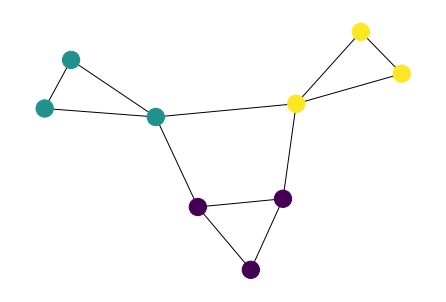

In [9]:
J = nx.Graph()
J.add_node(0, speed=0)
J.add_node(1, speed=0)
J.add_node(2, speed=0)

J.add_node(3, speed=10)
J.add_node(4, speed=10)
J.add_node(5, speed=10)

J.add_node(6, speed=20)
J.add_node(7, speed=20)
J.add_node(8, speed=20)

J.add_edges_from([(0, 1), (1, 2), (2, 0), (2, 3), 
                  (3, 4), (4, 5), (3, 5), (6, 7), 
                  (7, 8), (8, 6), (0, 6), (3, 6)])
nx.draw(J, node_color=[data["speed"] for _, data in J.nodes(data=True)])

In [10]:
s, _, _, _ = choose_sensors(J, "speed", evaluate_iterative_all, 3)
print(s)

  0%|          | 0/3 [00:00<?, ?it/s]

{0, 3, 7}


## Testing - Small Network

In [12]:
opt_sensors, idx2node, pred, x = choose_sensors(H, "vehicle_speed", evaluate_iterative_all, 43)

  0%|          | 0/43 [00:00<?, ?it/s]

In [13]:
nodes = pd.read_csv("out/" + city + ".nodes.csv", sep=";").set_index("node_id")
nodes.head()

,node_x,node_y
node_id,,
269459457,-118.215300,34.056067
317640716,-118.221778,34.036254
317640717,-118.221770,34.036083
317640718,-118.221753,34.035806
317640719,-118.221718,34.035521


In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

positions = {v: (k["node_x"], k["node_y"]) for v, k in nodes.to_dict("index").items()}
cmap = mpl.colormaps["viridis"]

G = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"],
                           create_using=nx.DiGraph)
G.number_of_edges()

1220

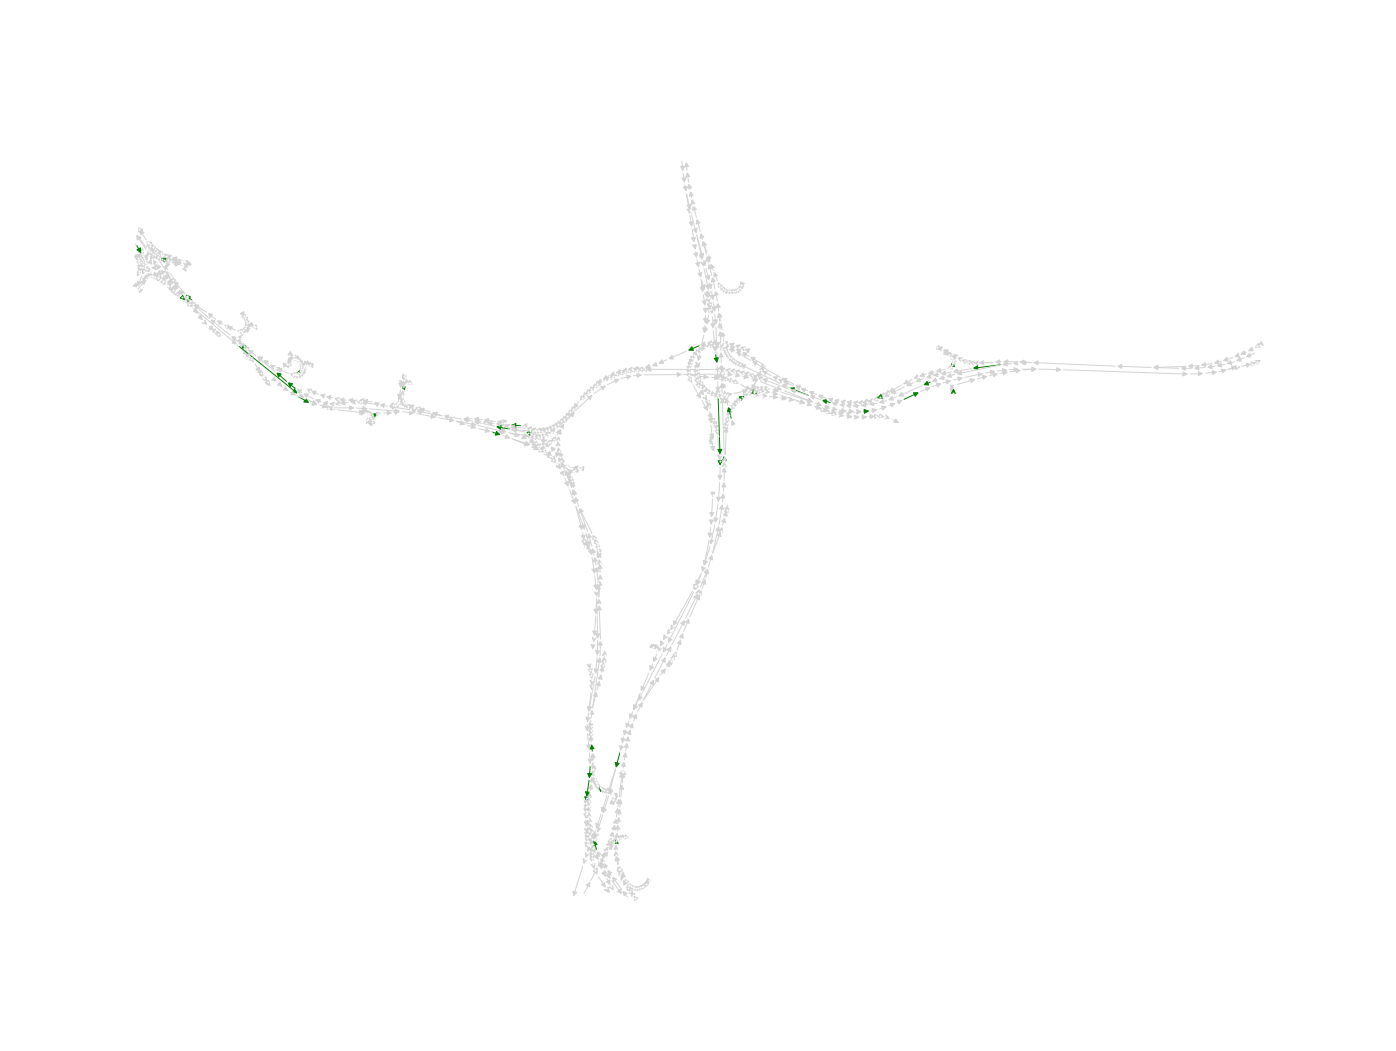

In [15]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

edge_colors = ["green" if (u, v) in opt_sensors or (v, u) in opt_sensors else "lightgray" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)

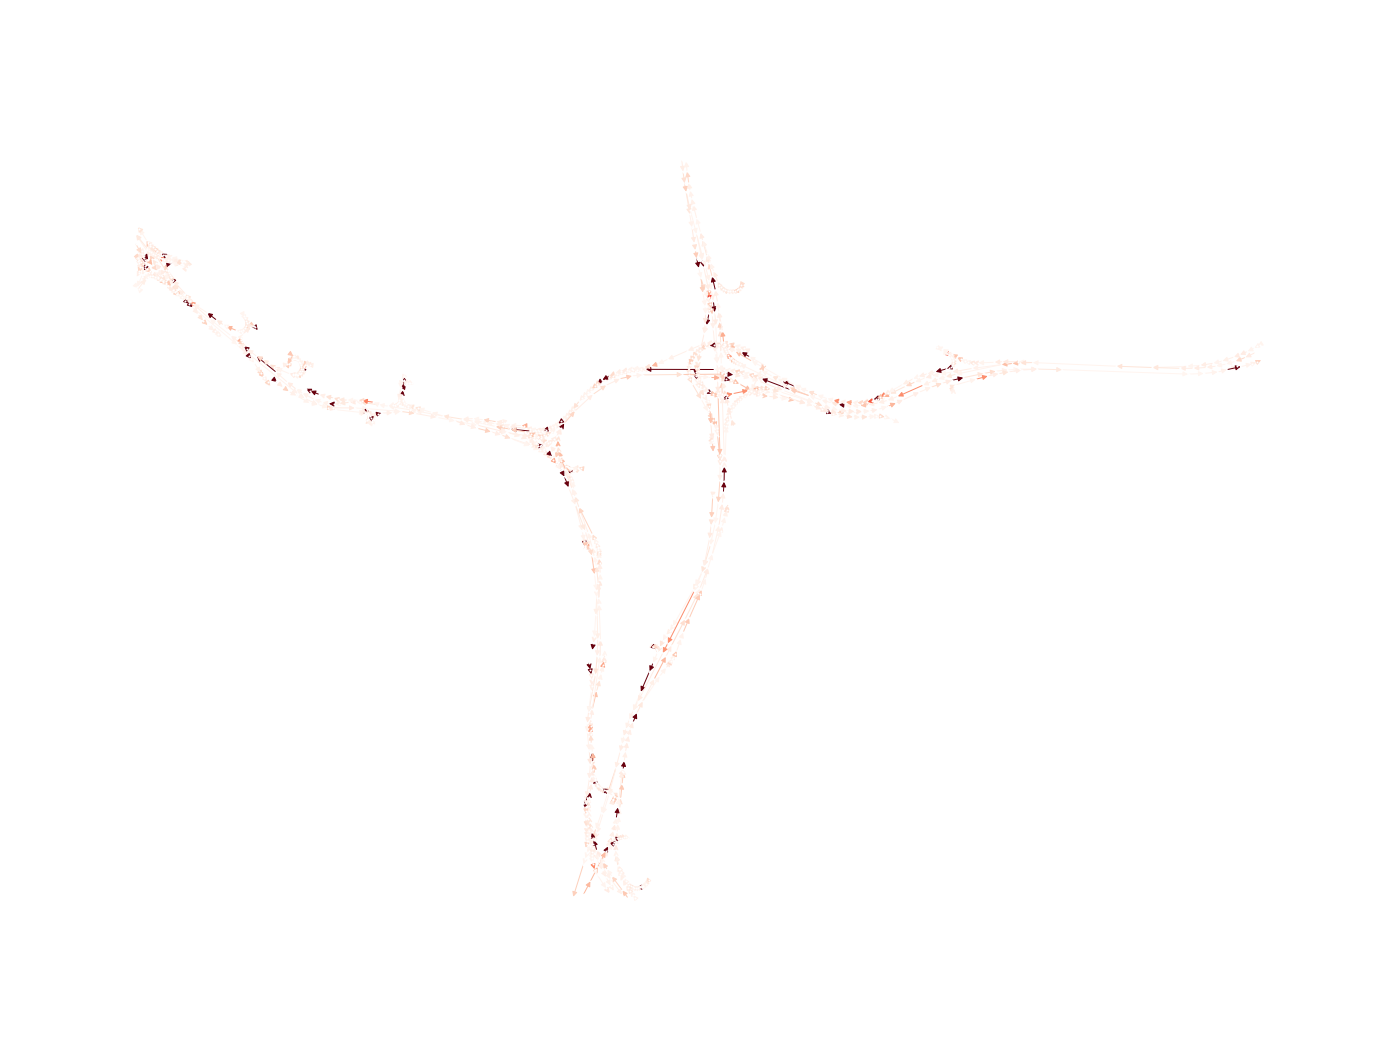

In [16]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

cmap = mpl.colormaps["Reds"]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=[cmap(abs(x_ - p) / (x_ + 1)) for p, x_ in zip(pred, x)])

## Benchmarks

In [38]:
"""
Choose k highest degree nodes in the graph. 
"""
def high_degree(G, k=None):
    if k == None:
        k = int(G.number_of_nodes() / 50)
        
    return [v[0] for v in sorted(G.degree, key=lambda x: x[1], reverse=True)[:k]]

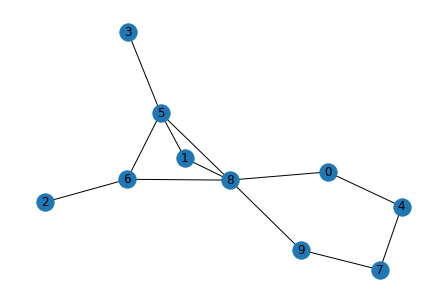

In [43]:
J = nx.erdos_renyi_graph(10, 0.4, seed=0)
nx.draw(J, with_labels=True)

In [44]:
high_degree(J, 3)

[8, 5, 6]

In [52]:
"""
Randomly select k nodes from the graph.
"""
def random(G, k=None):
    if k == None:
        k = int(G.number_of_nodes() / 50)
        
    return np.random.choice(G.nodes, k)

In [53]:
random(J, 2)

array([0, 5])

### TODO

Get benchmarks from active learning paper

## Error Metrics

In [54]:
def mape(x, pred):
    return sum([abs(x_ - p) / (x_ + 1e-4) for p, x_ in zip(pred, x)]) / len(x)

In [55]:
def mse(x, pred):
    return (np.square(pred - x)).mean()

In [56]:
"""
Maximum error across all nodes.
"""
def max_error(error):
    return lambda x, pred: max([error(x, pred)])

In [58]:
"""
Compute error on only a subset of nodes.
"""
def subset_error(x, pred, error, subset=None):
    
    pred_subset = np.copy(pred)
    if subset == None:
        subset = set(range(len(pred)))
    
    for i, _ in enumerate(pred):
        if i not in subset:
            pred[i] = x[i]
    
    return error(x, pred)